In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
#device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#set up seed for consistancy
torch.manual_seed(1)
batch_size = 64
#get MNIST dataset
data_train = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
#shuffle the labels for training
shuffled_labels = torch.tensor(np.random.randint(0, 10, (len(data_train)),))
#assign shuffled targets
data_train.targets = shuffled_labels
data_test = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=True)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,
                                         shuffle=False)

In [4]:
#Define model 1 
model_one = nn.Sequential(
                nn.Linear(784,400),
                nn.ReLU(),
                nn.Linear(400,9),
                nn.ReLU(),
                nn.Linear(9,10)
                )

In [5]:
cnn_model_one = model_one
#cnn_model_one.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(cnn_model_one.parameters(), lr=0.001, momentum=0.9)

In [6]:
def trainModel(model):
    n_correct = 0
    n_samples = 0
    count = 0 
    loss_per_batch = 0
    for i, (inputs, labels) in enumerate(train_loader): 
        count +=1
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_sgd.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs.view(-1,784)).to(device)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
        loss_per_batch += loss.data

        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
    
    #print(model.named_parameters())
    loss_per_batch /= count
    return loss_per_batch

In [7]:
max_epochs = 24
n_loss_train=[]
x_points=[]
y_points=[]
x_points2=[]
y_points2=[]
first_layer_weights={}
all_weights={}
pca = PCA(n_components=2)
for i in range(8):
    tempList=[]
    tempList2=[]
    for epoch in range(max_epochs):
        loss_train=trainModel(cnn_model_one)
        n_loss_train.append(loss_train)
        if epoch % 3 == 0:
            tmp = []
            for name, parameter in cnn_model_one.named_parameters():
            #print(name)
                if'weight' in name :
                    tmp.extend(np.reshape(torch.nn.utils.parameters_to_vector(parameter).detach().numpy(), -1))
                    #tmp = np.array(tmp)
                    tempList.append(tmp)
                if'0.weight' in name :
                    tempList2.append(torch.nn.utils.parameters_to_vector(parameter).detach().numpy())
    principalComponents = pca.fit_transform(tempList)
    x_points.append(principalComponents[:,0])
    y_points.append(principalComponents[:,1])   
    principalComponents = pca.fit_transform(tempList2)
    x_points2.append(principalComponents[:,0])
    y_points2.append(principalComponents[:,1])
    first_layer_weights[i]= tempList2
    all_weights[i]= tempList
    #print(cnn_model_one.named_parameters())
    #print('Epoch ', epoch, 'Loss Train ',loss_train ,'Loss Test',loss_test)

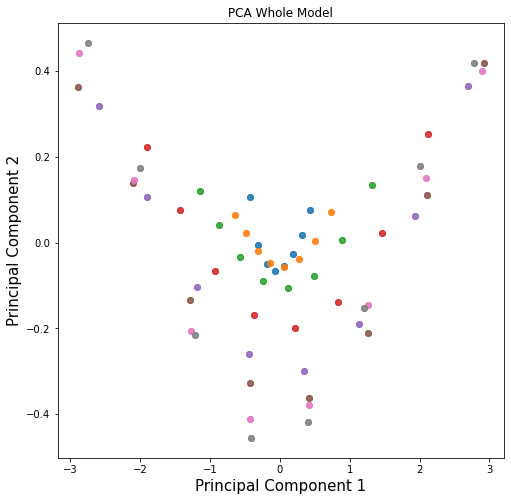

In [8]:
pca = PCA(n_components=2)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
plt.title('PCA Whole Model')


for key in all_weights:
    #print(first_layer_weights[key])
    principalComponents = pca.fit_transform(all_weights[key])
    ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.5)


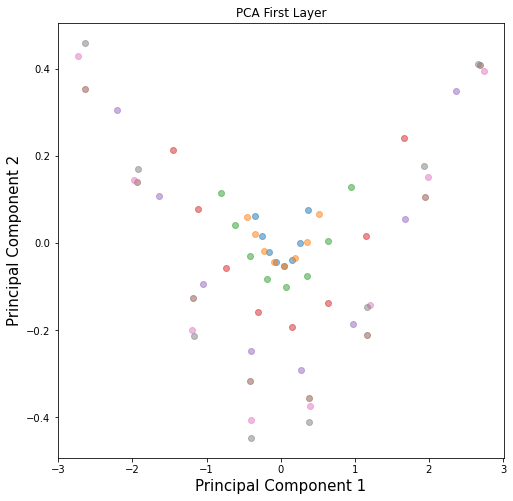

In [9]:
pca = PCA(n_components=2)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
plt.title('PCA First Layer')


for key in first_layer_weights:
    #print(first_layer_weights[key])
    principalComponents = pca.fit_transform(first_layer_weights[key])
    ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.5)
